Projet : Accident de la route
==============

## Contexte

L’objectif de ce projet est d’essayer de prédire la gravité des accidents routiers en France. Les prédictions seront basées sur les données historiques.

La première étape est d’étudier et appliquer des méthodes pour nettoyer le jeu de données.
La deuxième étape est d’extraire les caractéristiques qui semblent être pertinentes pour estimer la gravité d’accidents.

On pourra créer un modèle prédictif, une fois l’entraînement du modèle effectué, nous allons comparer notre modèle avec les données historiques.
Ensuite, à partir de ces résultats, on peut développer un scoring des zones à risque en fonction des informations météorologiques, l’emplacement géographique (coordonnées GPS, images satellite, …)



### Informations sur les données

Les données vont de 2005 à 2022, elles sont annuelles et composées de 4 fichiers (Caractéristiques – Lieux – Véhicules – Usagers) au format csv. Les données ont été anonymisées par le service de gouvernement.
Les données répertorient l'intégralité des accidents corporels de la circulation sur le territoire français (France métropolitaine et les DOM-TOM).
Le n° d'identifiant de l’accident (Cf. "Num_Acc") présent dans ces 4 rubriques permet d'établir un lien entre toutes les variables qui décrivent un accident.\
Quand un accident comporte plusieurs véhicules, il faut aussi pouvoir le relier chaque véhicule à ses occupants. Ce lien est fait par la variable id_vehicule.


La variable cible est "grav" dans le dataset d'usagers.


### Notions introduites :
Qu'est-ce qui peut définir un accident comme grave ?
Il y a :
- le type d'accident,
- la temporalité de l'accident (date et heure),
- le lieu de l'accident,
- les caractéristiques de l'accident,
- les informations météorologiques de l'accident,
- l'emplacement géographique de l'accident,
- les circuits de l'accident.

Selon l'OMS, en 2023, 53% des décès dus aux accidents concernent des usagers de la route vulnérables, notamment : les piétons (23 %) ; les conducteurs de deux-roues et de trois-roues motorisés tels que les motocyclettes (21 %) ; les cyclistes (6 %) ; et les usagers d’engins de micro-mobilité comme les trottinettes électriques (3 %).

D'après les données disponibles pour 2021 de la commission européenne, 52 % des décès dus à des accidents de la route sont survenus en zone rurale, contre 39 % en zone urbaine et 9 % sur des autoroutes. Trois victimes sur quatre (78 %) sont des hommes.

En zone urbaine, les usagers vulnérables de la route (piétons, cyclistes et usagers de deux-roues motorisés) représentent près de 70 % du total des décès.

### Import des données

In [1]:
# import des librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# librairie pour afficher toutes les colonnes du dataframe
pd.set_option('display.max_columns', None)
pd.options.display.max_info_columns

100

In [2]:
# import du dataset : usagers impliqués
df_usa22 = pd.read_csv("dataset/usagers-2022.csv", sep=';')
df_usa21 = pd.read_csv("dataset/usagers-2021.csv", sep=';')
df_usa20 = pd.read_csv("dataset/usagers-2020.csv", sep=';')
df_usa19 = pd.read_csv("dataset/usagers-2019.csv", sep=';')

# regrouper les datasets usagers en 1 dataset usager
df_usa = pd.concat([df_usa22, df_usa21,df_usa20,df_usa19])
df_usa.head()

,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202200000001,1 099 700,813 952,A01,1,1,3,1,2008.0,5,2,8,-1,-1,-1,-1
1,202200000001,1 099 701,813 953,B01,1,1,1,1,1948.0,5,1,8,-1,-1,-1,-1
2,202200000002,1 099 698,813 950,B01,1,1,4,1,1988.0,9,1,0,-1,0,0,-1
3,202200000002,1 099 699,813 951,A01,1,1,1,1,1970.0,4,1,0,-1,0,0,-1
4,202200000003,1 099 696,813 948,A01,1,1,1,1,2002.0,0,1,0,-1,-1,-1,-1


On observe 2 lignes pour le même numéro d'accident, il s'agit non pas d'un doublon mais de 2 usagers différents impliqués dans l'accident.

In [3]:
# import des datasets des lieux des accidents : décrit le lieu principal de l’accident même si celui-ci s’est déroulé à une intersection
df_lieux22 = pd.read_csv("dataset/lieux-2022.csv", sep=';')
df_lieux21 = pd.read_csv("dataset/lieux-2021.csv", sep=';')
df_lieux20 = pd.read_csv("dataset/lieux-2020.csv", sep=';')
df_lieux19 = pd.read_csv("dataset/lieux-2019.csv", sep=';')

# regrouper les datasets en 1 seul dataset lieux
df_lieux = pd.concat([df_lieux22, df_lieux21, df_lieux20, df_lieux19])
df_lieux.head()

C:\Users\thfam\AppData\Local\Temp\ipykernel_29760\560646412.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lieux22 = pd.read_csv("dataset/lieux-2022.csv", sep=';')


,Num_Acc,catr,voie,v1,v2,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,202200000001,4,TEIL(vieille route du),0.0,NaN,2,2,0,1,(1),(1),1,NaN,-1,1,0,1,50
1,202200000002,4,NaN,0.0,NaN,2,2,0,1,(1),(1),1,NaN,-1,1,0,1,50
2,202200000003,3,ROND POINT DE BREZILLET,0.0,NaN,-1,2,0,1,0,0,1,NaN,-1,1,5,1,50
3,202200000004,4,QUATORZE JUILLET (RUE DU),0.0,NaN,1,1,0,2,(1),(1),1,NaN,4,1,0,1,30
4,202200000005,3,ROUTE DE JEAN MOULIN-RN 538,0.0,NaN,2,2,0,1,8,0,1,NaN,-1,1,0,1,80


In [4]:
# import des datasets des caractéristiques des accidents : décrit les circonstances générales de l’accident
df_carac22 = pd.read_csv("dataset/carcteristiques-2022.csv", sep=';')
df_carac21 = pd.read_csv("dataset/carcteristiques-2021.csv", sep=';')
df_carac20 = pd.read_csv("dataset/caracteristiques-2020.csv", sep=';')
df_carac19= pd.read_csv("dataset/caracteristiques-2019.csv", sep=';')
df_carac22['Num_Acc'] = df_carac22['Accident_Id']

# regrouper les datasets en 1 seul dataset caractéristiques
df_car = pd.concat([df_carac22, df_carac21,df_carac20,df_carac19])
df_car.head()

,Accident_Id,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long,Num_Acc
0,2.022000e+11,19,10,2022,16:15,1,26,26198,2,3,1,3,TEIL(vieille route du),"44,5594200000","4,7257200000",202200000001
1,2.022000e+11,20,10,2022,08:34,1,25,25204,2,3,1,3,Miranda,"46,9258100000","6,3462000000",202200000002
2,2.022000e+11,20,10,2022,17:15,1,22,22360,2,6,1,2,ROND POINT DE BREZILLET,"48,4931620000","-2,7604390000",202200000003
3,2.022000e+11,20,10,2022,18:00,1,16,16102,2,3,8,6,LOHMEYER (RUE),"45,6926520000","-0,3262900000",202200000004
4,2.022000e+11,19,10,2022,11:45,1,13,13103,1,1,1,2,ROUTE DE JEAN MOULIN-RN 538,"43,6755790366","5,0927031775",202200000005


In [5]:
# import des datasets des véhicules impliqués dans des accidents
df_veh22 = pd.read_csv("dataset/vehicules-2022.csv", sep=';')
df_veh21 = pd.read_csv("dataset/vehicules-2021.csv", sep=';')
df_veh20 = pd.read_csv("dataset/vehicules-2020.csv", sep=';')
df_veh19 = pd.read_csv("dataset/vehicules-2019.csv", sep=';')

# regrouper les datasets en 1 seul dataset véhicules
df_veh = pd.concat([df_veh22, df_veh21, df_veh20, df_veh19])
df_veh.head()

,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc
0,202200000001,813 952,A01,1,2,0,2,1,9,1,NaN
1,202200000001,813 953,B01,1,7,0,2,2,1,1,NaN
2,202200000002,813 950,B01,2,7,0,2,8,15,1,NaN
3,202200000002,813 951,A01,2,10,0,2,1,1,1,NaN
4,202200000003,813 948,A01,2,7,0,2,1,2,1,NaN


On observe 2 lignes pour le même numéro d'accident, il s'agit non pas d'un doublon mais de 2 véhicules différents impliqués dans l'accident.

#### Regrouper les 4 datasets en 1 dataset

In [6]:
df_lieux['Num_Acc'] = df_lieux['Num_Acc'].astype(str)
df_car['Num_Acc'] = df_car['Num_Acc'].astype(str)
df_veh['Num_Acc'] = df_veh['Num_Acc'].astype(str)
df_usa['Num_Acc'] = df_usa['Num_Acc'].astype(str)

# merge les datasets ensembles
df_temp = pd.merge(df_usa, df_lieux, on="Num_Acc") # usagers + lieux
df_temp_2 = pd.merge(df_temp, df_car, on="Num_Acc") # usagers et lieux + caractéristiques
df = pd.merge(df_temp_2, df_veh, on = ["Num_Acc", "id_vehicule", "num_veh"]) # usagers et lieux et caractéristiques + vehicules

# supprimer les doublons
df.drop_duplicates(keep='first')

print(df.shape)
df.head()

################## ajouté par Thierry ##################################
df.to_csv('dataset/dataset_analyse.csv', index=False)

(494182, 56)


## Data exploration

In [7]:
df.shape

(494182, 56)

In [8]:
df.dtypes.value_counts()

int64      34
object     18
float64     4
Name: count, dtype: int64

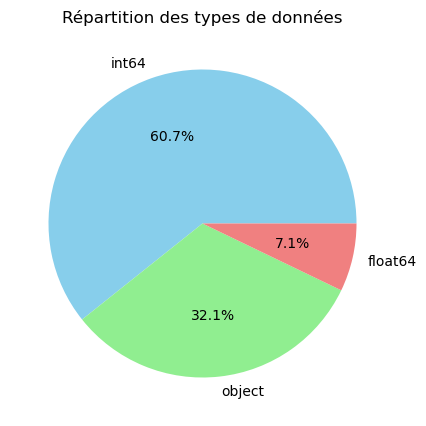

In [9]:
plt.figure(figsize=(5,5))
plt.title("Répartition des types de données")
df.dtypes.value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral'])
plt.ylabel('')
plt.show();

#### Affichage des données manquantes par colonnes

In [10]:
# Fonction pour mettre en évidence les données manquants et leur donner un pourcentage
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
missing_values_table(df)

Your selected dataframe has 56 columns.
There are 10 columns that have missing values.


,Missing Values,% of Total Values
lartpc,493100,99.8
occutc,487970,98.7
v2,454640,92.0
Accident_Id,367520,74.4
id_usager,238272,48.2
larrout,132146,26.7
voie,47564,9.6
v1,24596,5.0
adr,6051,1.2
an_nais,5941,1.2


<Axes: >

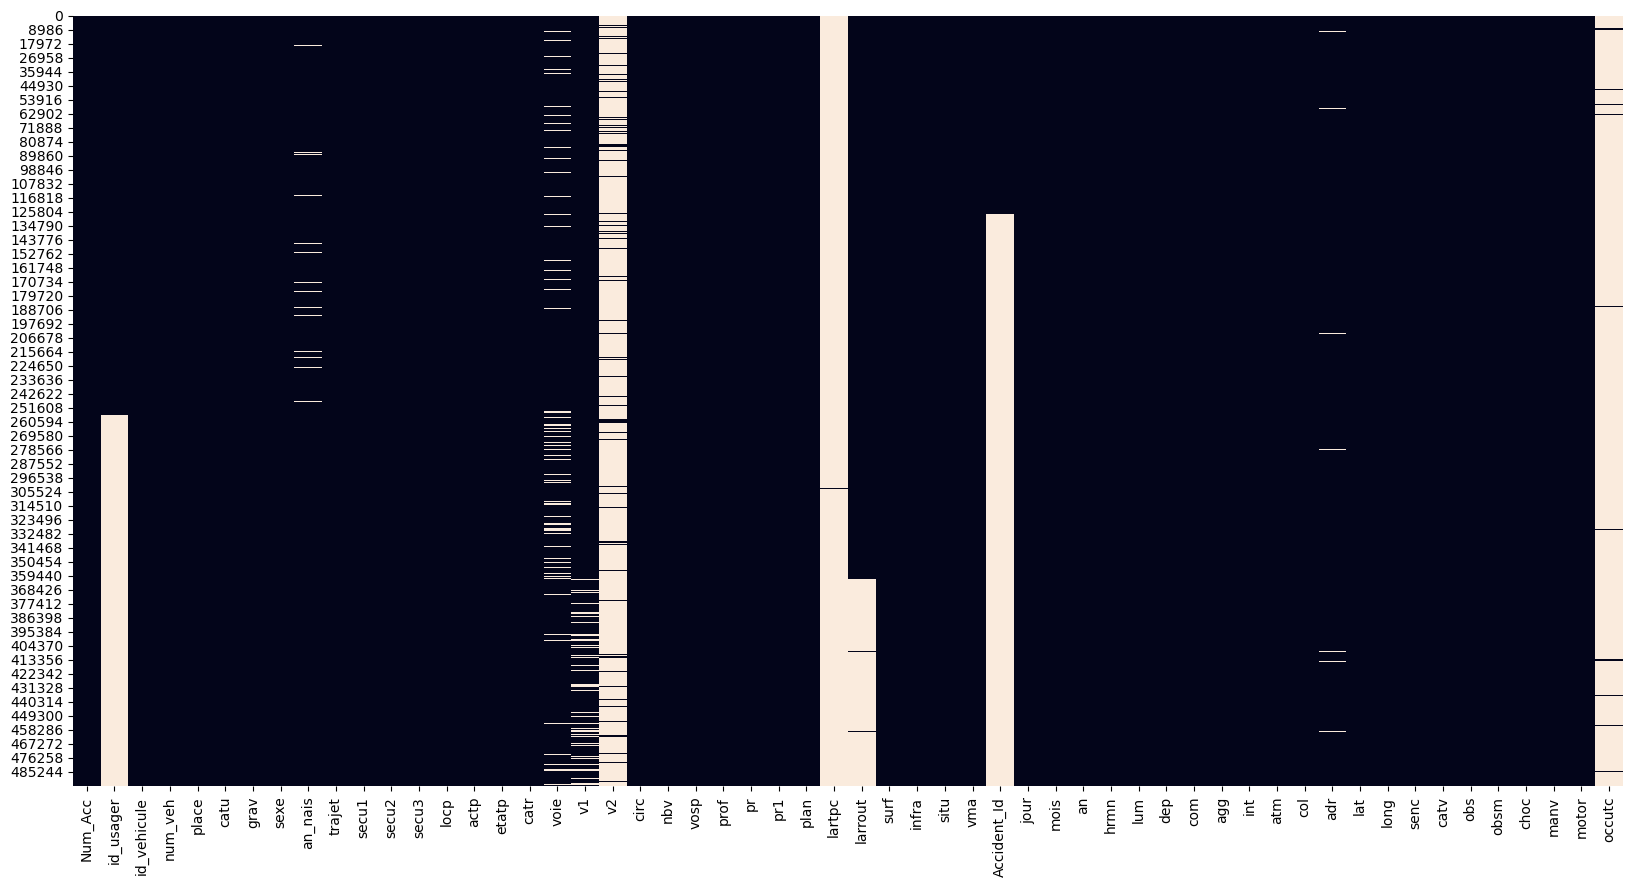

In [11]:
# Affichage d'un heatmap pour voir les nan
plt.figure(figsize = (20, 10))
sns.heatmap(df.isna(), cbar = False)

On supprime les colonnes ayant plus de 90 % de manquants.

### Répartition des données

In [12]:
df.describe()

,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,etatp,catr,v1,circ,vosp,prof,plan,surf,infra,situ,vma,Accident_Id,jour,mois,an,lum,agg,int,atm,col,senc,catv,obs,obsm,choc,manv,motor,occutc
count,494182.000000,494182.000000,494182.000000,494182.000000,488241.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,469586.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,1.266620e+05,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,6212.000000
mean,2.103371,1.334992,2.531620,1.289149,1982.037854,3.210248,1.945607,1.120652,-0.915798,-0.189758,-0.825056,3.290249,-0.129604,1.836520,0.186393,1.234806,1.289029,1.258105,0.810580,1.464602,60.749028,2.022000e+11,15.673080,6.732609,2020.505067,1.904165,1.621257,2.049138,1.607139,3.759184,1.557111,12.516565,1.124928,1.571923,2.879540,7.104259,1.210623,5.555055
std,2.604504,0.615593,1.376507,0.525390,18.964197,2.747711,2.325931,3.127138,0.886670,1.219173,0.624203,1.289259,0.361500,0.900093,0.644271,0.549586,0.668092,0.808749,2.167729,1.393347,25.560521,1.593056e+04,8.750957,3.361416,1.140509,1.478298,0.485074,1.988583,1.675451,1.898749,0.827476,13.130049,3.258731,1.193070,2.396285,8.065784,1.029739,8.491504
min,-1.000000,1.000000,-1.000000,-1.000000,1900.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.022000e+11,1.000000,1.000000,2019.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1969.000000,0.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3.000000,0.000000,2.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,50.000000,2.022000e+11,8.000000,4.000000,2019.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,7.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,3.000000,1.000000,1985.000000,4.000000,1.000000,0.000000,-1.000000,0.000000,-1.000000,3.000000,0.000000,2.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,50.000000,2.022000e+11,16.000000,7.000000,2021.000000,1.000000,2.000000,1.000000,1.000000,3.000000,1.000000,7.000000,0.000000,2.000000,2.000000,2.000000,1.000000,2.000000
75%,2.000000,2.000000,4.000000,2.000000,1997.000000,5.000000,2.000000,0.000000,-1.000000,0.000000,-1.000000,4.000000,0.000000,2.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,80.000000,2.022000e+11,23.000000,10.000000,2022.000000,3.000000,2.000000,2.000000,1.000000,6.000000,2.000000,10.000000,0.000000,2.000000,4.000000,15.000000,1.000000,5.000000
max,10.000000,3.000000,4.000000,2.000000,2022.000000,9.000000,9.000000,9.000000,9.000000,9.000000,3.000000,9.000000,3.000000,4.000000,3.000000,4.000000,4.000000,9.000000,9.000000,8.000000,901.000000,2.022001e+11,31.000000,12.000000,2022.000000,5.000000,2.000000,9.000000,9.000000,7.000000,3.000000,99.000000,17.000000,9.000000,9.000000,26.000000,6.000000,38.000000


### Nombre de valeurs unique

In [13]:
df.nunique()

Num_Acc        218404
id_usager      255910
id_vehicule    369639
num_veh            77
place              11
catu                3
grav                5
sexe                3
an_nais           110
trajet              8
secu1              11
secu2              11
secu3              11
locp               11
actp               13
etatp               4
catr                8
voie            37236
v1                  4
v2                 44
circ                5
nbv                29
vosp                5
prof                5
pr                632
pr1              1473
plan                5
lartpc             65
larrout           235
surf               10
infra              11
situ                8
vma                47
Accident_Id     55302
jour               31
mois               12
an                  4
hrmn             1438
lum                 6
dep               116
com             21259
agg                 2
int                10
atm                10
col                 8
adr       

### Distribution des données

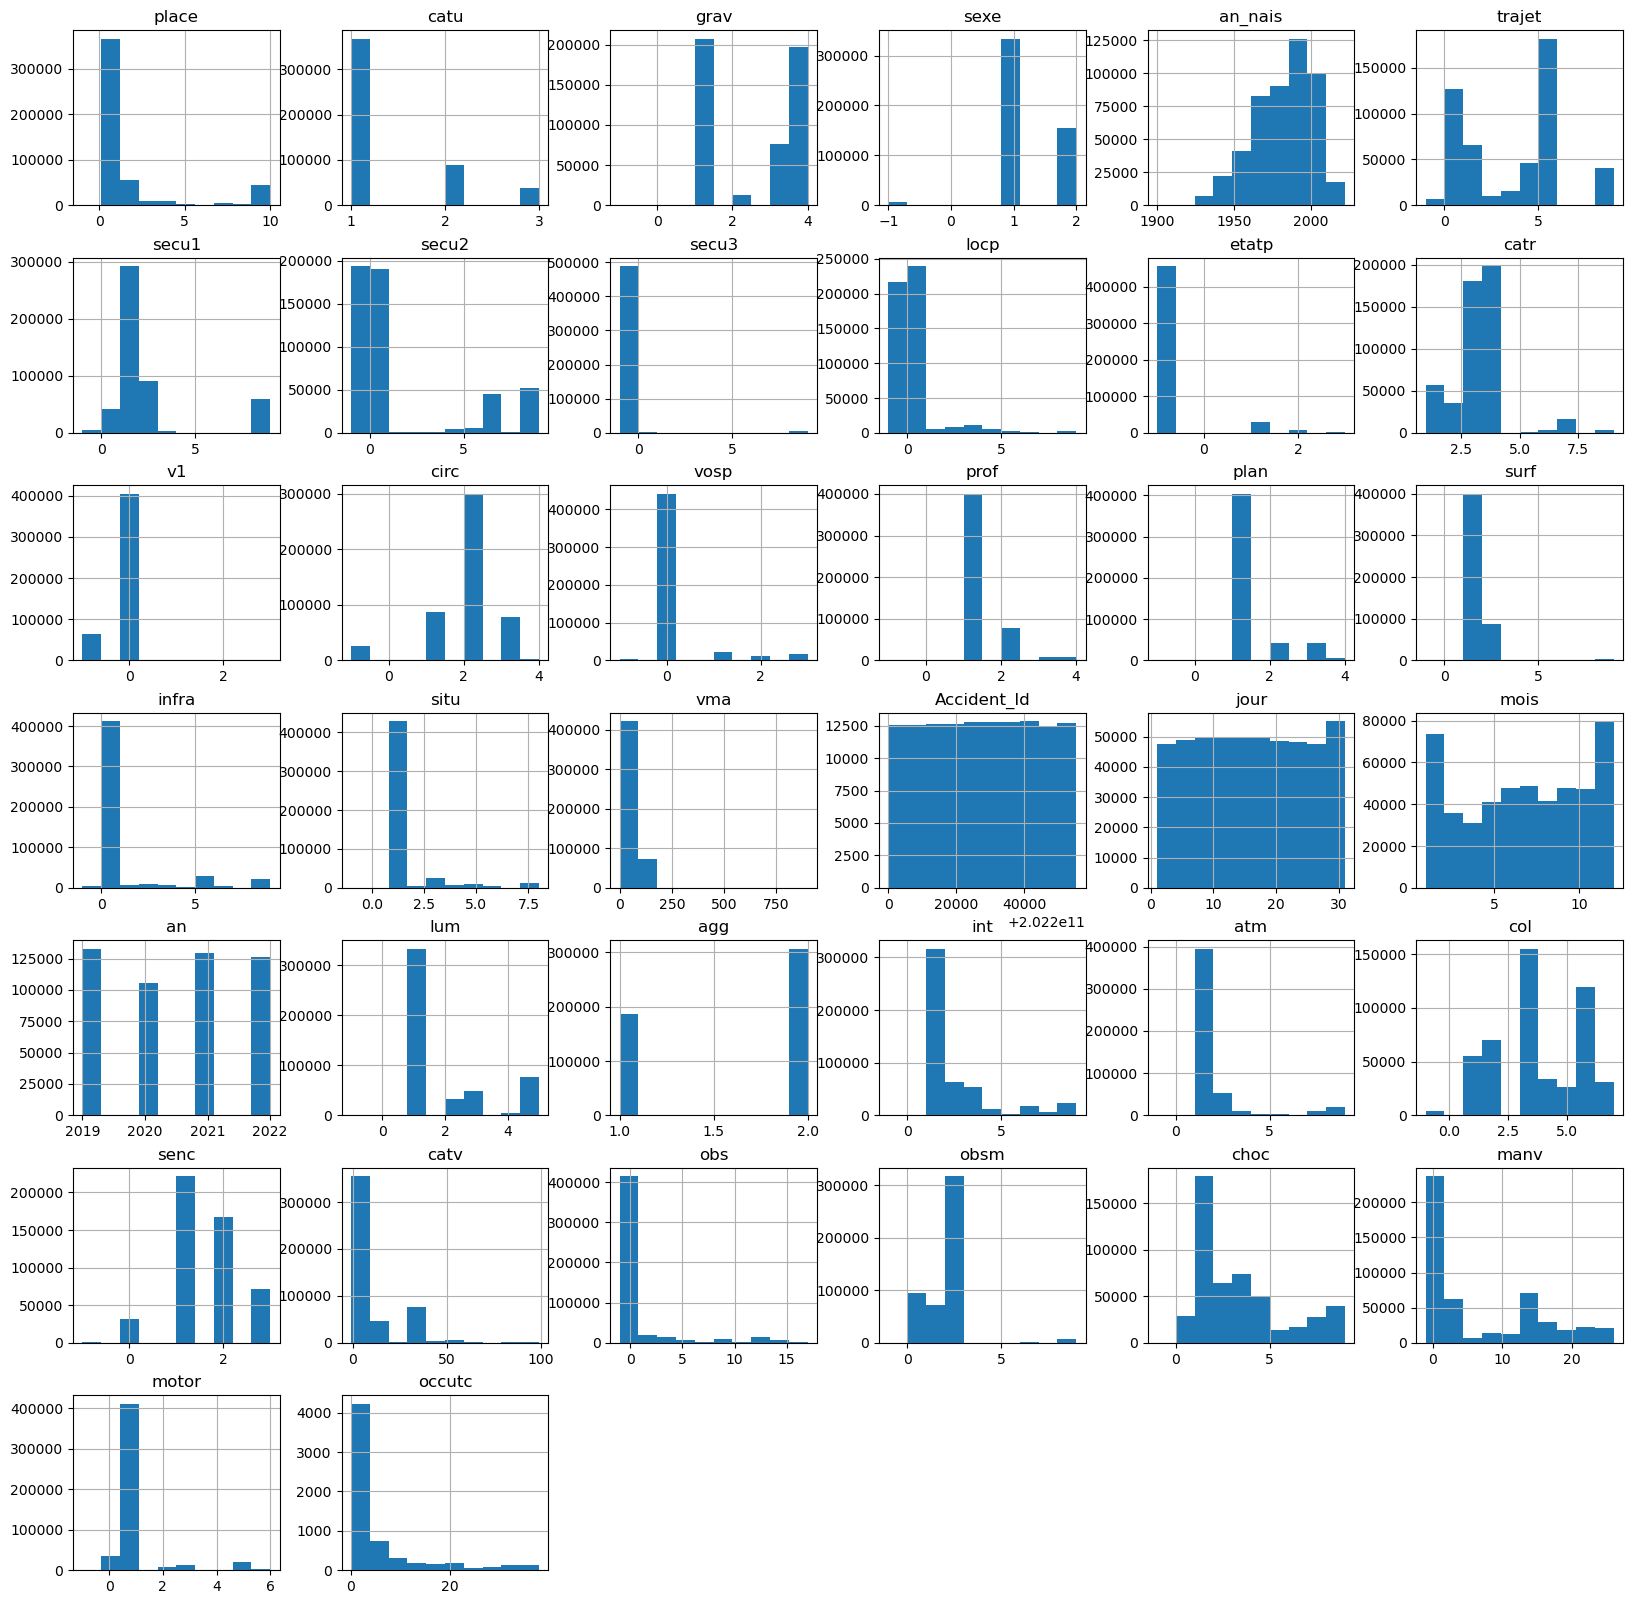

In [14]:
df.hist(figsize=(20, 20))
plt.show()

## Visualisation des données

### Profil des usagers ayant eu des accident

Deux analyses sont réalisées pour les usagers ayant eu des accident :
- Nombre d'accidents en fonction du genre
- Nombre d'accidents en fonction de l'âge

#### Analyse en fonction du genre

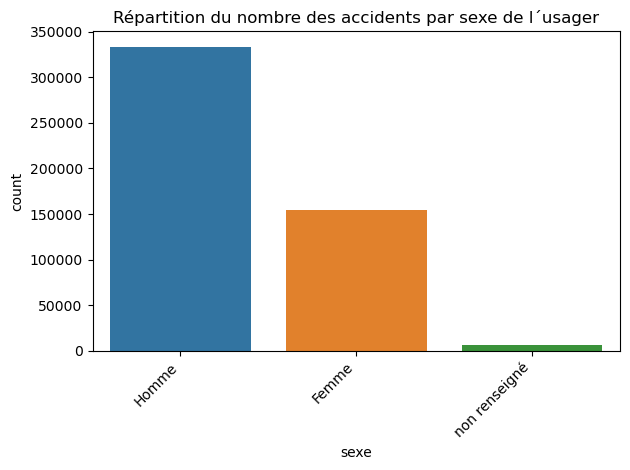

In [15]:
## Afficher la nouvelle répartition de la valeur cible
df_modified = df.copy()
df_modified['sexe'] = df_modified['sexe'].replace({
   -1: 'non renseigné',
    1: 'Homme',
    2: 'Femme',
})

sns.countplot(x='sexe', data=df_modified)

# Personnaliser les étiquettes de l'axe x avec rotation oblique
plt.xticks(rotation=45, ha='right')  # Rotation de 45 degrés, alignées à droite

# Ajouter un titre au graphique
plt.title('Répartition du nombre des accidents par sexe de l´usager')

# Afficher le graphique
plt.tight_layout()  # Ajuster la mise en page pour éviter la coupure des étiquettes
plt.show()

Les hommes sont fortement représentés dans les accidents. Il y a des profils d'usagers dont le genre n'a pas été renseigné.

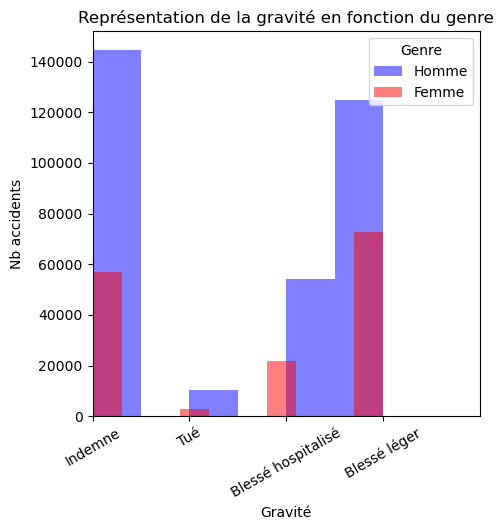

In [16]:
# Représentation des accidents en fonction du genre et de la gravité

# création d'un df dont le genre de la personne est renseigné
df_genre = df.copy()
df_genre = df.loc[(df['sexe'] == 1) | (df['sexe'] == 2)]

colors = {1: 'blue', 2: 'red'}
labels = {1: 'Homme', 2: 'Femme'}

plt.figure(figsize=(5, 5))

for sexe, data in df_genre.groupby('sexe'):
    plt.hist(data['grav'], color=colors[sexe], label=labels[sexe], alpha=0.5)

plt.legend(title='Genre')
plt.xlabel('Gravité')
plt.xlim(1,5)
plt.xticks([1, 2, 3, 4], ['Indemne', 'Tué' ,'Blessé hospitalisé','Blessé léger'], rotation=30)
plt.ylabel('Nb accidents')
plt.title('Représentation de la gravité en fonction du genre')
plt.show()

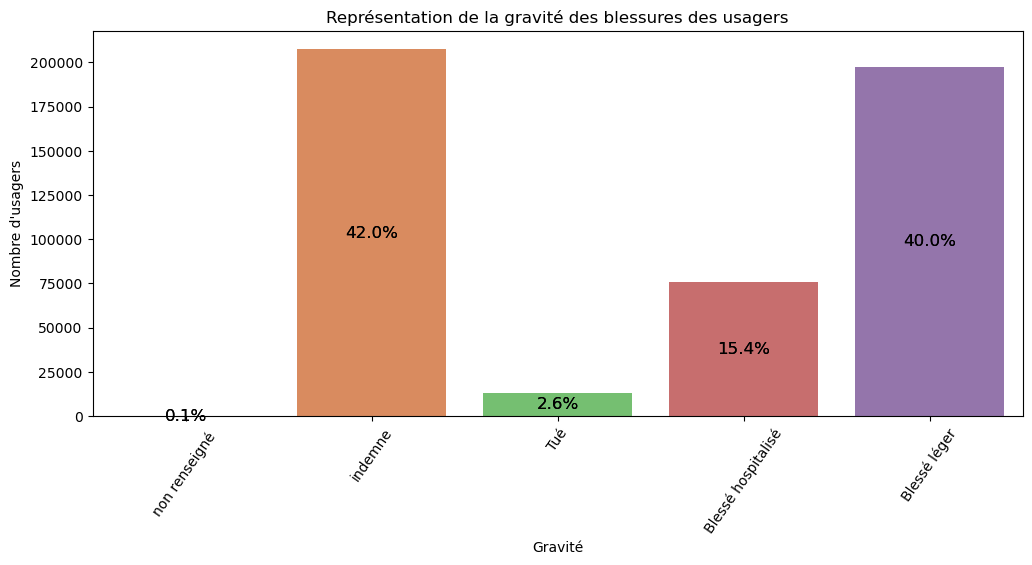

In [17]:
# Représentation de la gravité des blessures des usagers

plt.figure(figsize = (12,5))
sns.countplot(x = df_usa['grav'])

grav = ['non renseigné ', 'indemne', 'Tué', 'Blessé hospitalisé', 'Blessé léger']

# Créer le graphique countplot
ax = sns.countplot(x=df_usa['grav'], palette="muted")
# Calculer et annoter les pourcentages sur les barres
total = len(df_usa['grav'])
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax.text(p.get_x() + p.get_width() / 2., height / 2,
    percentage, ha="center", va="center", color="black", fontsize=12)


plt.xticks(range(0, len(df_usa['grav'].value_counts())), grav, rotation = 55)

plt.title("Représentation de la gravité des blessures des usagers" )
plt.xlabel("Gravité")
plt.ylabel("Nombre d'usagers")
plt.show()

#### Analyse en fonction de l'âge

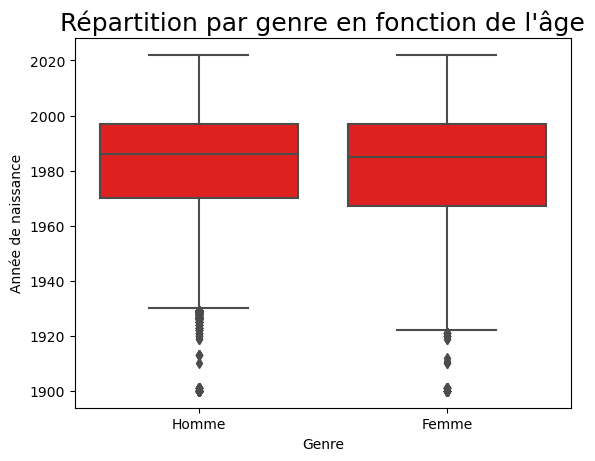

In [18]:
sns.boxplot(data=df_genre, x='sexe', y='an_nais', color='red')

plt.title("Répartition par genre en fonction de l'âge", fontsize =18)
plt.xticks([0, 1], ['Homme', 'Femme'])
plt.xlabel("Genre")
plt.ylabel("Année de naissance")
plt.show;

C:\Users\thfam\anaconda3\envs\Projet_accidents_routiers\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x500 with 0 Axes>

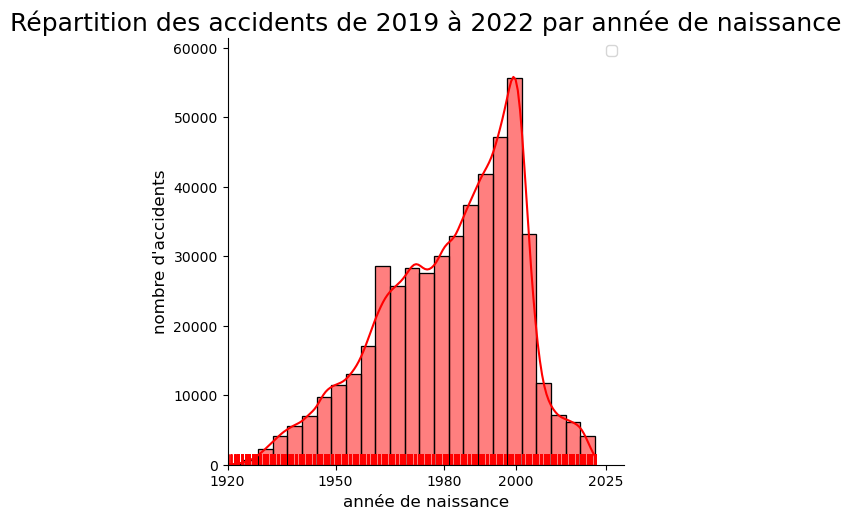

In [19]:
# Nombre d'accidents en fonction de l'âge
plt.figure(figsize= (10, 5))
sns.displot(df.an_nais, kde=True, bins=30, rug = True, color='red')

plt.xlabel("année de naissance", fontsize = 12)
plt.ylabel("nombre d'accidents", fontsize = 12)
plt.xticks([1920, 1950, 1980, 2000, 2025])
plt.xlim([1920, 2030])
plt.title('Répartition des accidents de 2019 à 2022 par année de naissance', fontsize = 18)
plt.legend();

In [20]:
print("L'usager le plus âgé impliqué dans un accident est né en :", df.an_nais.min(),
      "et l'usager le plus jeune impliqué dans un accident est né en :", df.an_nais.max())

L'usager le plus âgé impliqué dans un accident est né en : 1900.0 et l'usager le plus jeune impliqué dans un accident est né en : 2022.0


On observe une forte représentation de profil d'usagers ayant la vingtaine qui a été impliqués dans un accident.

Pour **conclure** sur le profil des usagers ayant eu des accident, il y a une forte représentation d'hommes, et d'âge proche de la vingtaine.

### Typologie des accidents

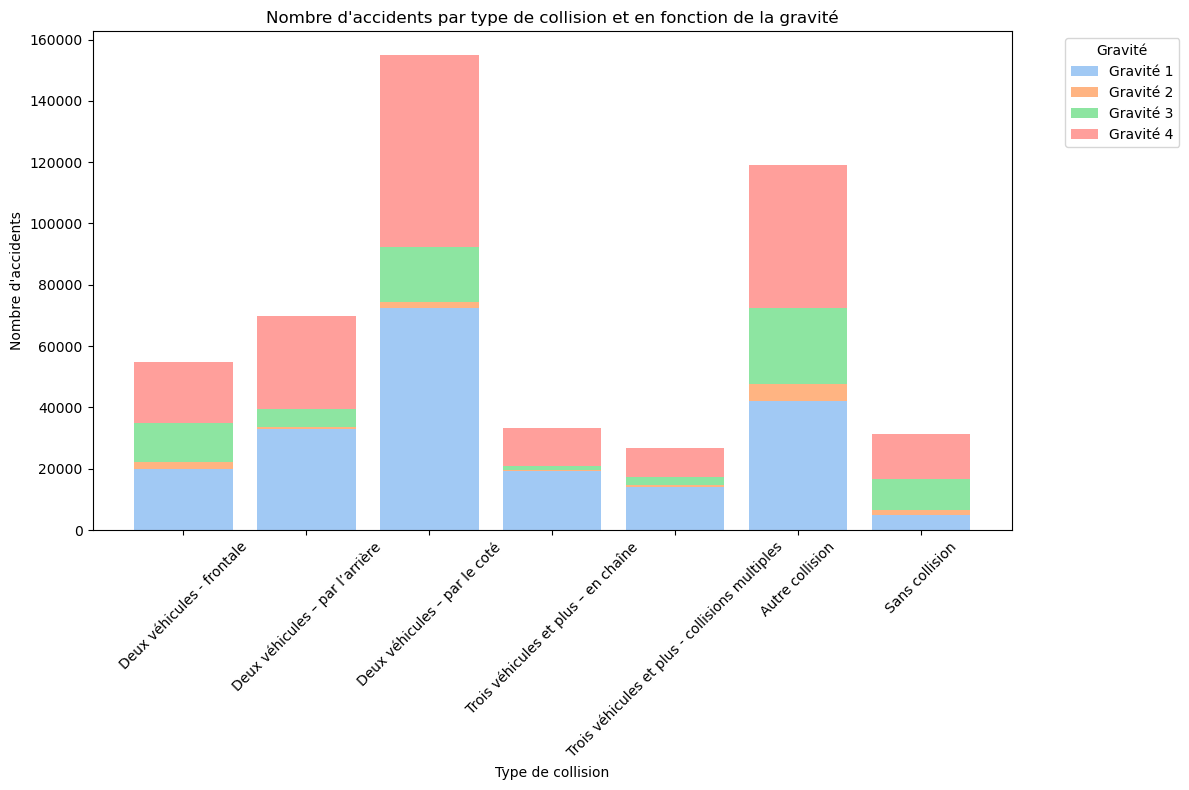

In [21]:
df_col = df.loc[(df['col'] >= 1) & (df['grav'] >= 1)]

collision_labels = {
    1: 'Collision avec véhicule',
    2: 'Collision avec piéton',
    3: 'Collision avec animal',
    4: 'Sortie de route',
    5: 'Collision avec obstacle',
    6: 'Collision multiple',
    7: 'Autres'
}

cross_tab = pd.crosstab(df_col['col'], df_col['grav'], rownames=['Type de Collision'], colnames=['Gravité'])

pastel_palette = sns.color_palette("pastel", n_colors=cross_tab.shape[1])

plt.figure(figsize=(12, 8))

for i, col in enumerate(cross_tab.columns):
    plt.bar(cross_tab.index, cross_tab[col], bottom=cross_tab.iloc[:, :i].sum(axis=1), color=pastel_palette[i], label=f'Gravité {col}')

plt.xlabel('Type de collision')
plt.ylabel('Nombre d\'accidents')
plt.title('Nombre d\'accidents par type de collision et en fonction de la gravité')
plt.xticks([1,2,3,4,5,6,7], ["Deux véhicules - frontale","Deux véhicules – par l’arrière","Deux véhicules – par le coté",
                            "Trois véhicules et plus – en chaîne","Trois véhicules et plus - collisions multiples","Autre collision","Sans collision"], rotation=45)
plt.legend(title='Gravité', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

On observe que le type de collision le plus fréquent est un accident impliquant 2 véhicules ont une collision par le coté. La catégorie 'autre collision' étant trop vague, on ne pourra pas l'expliquer. Il est possible que ce sont des accidents où les véhicules ne sont pas impliqués.

#### Nombre d'accidents entre 2019 et 2022

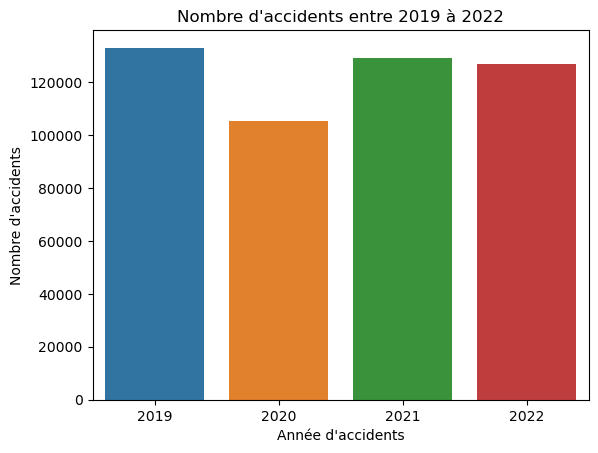

In [22]:
df['grav'].sum() # 1 251 081 tués de 2019 à 2022

df['Num_Acc'] = df['Num_Acc'].astype(str)
df['an_acc'] = df['Num_Acc'].str.slice(0,4).astype(int)

sns.countplot(x = df['an_acc'])

plt.title("Nombre d'accidents entre 2019 à 2022")
plt.xlabel("Année d'accidents")
plt.ylabel("Nombre d'accidents")
plt.show();

On observe une baisse des accidents en 2020, cela est peut être dû aux confinements et aux restrictions suite à la période Covid.

#### Représentation de la gravité des accidents par année d'accidents

In [23]:
# dataframe sur la distribution des accidents en fonction de leur gravité
df.loc[df['grav'] >= 1].groupby(['an', 'grav']).size().unstack()

grav,1,2,3,4
an,,,,
2019,55314,3498,20858,53307
2020,43267,2780,16775,42473
2021,55143,3219,19093,51733
2022,53630,3550,19260,49981


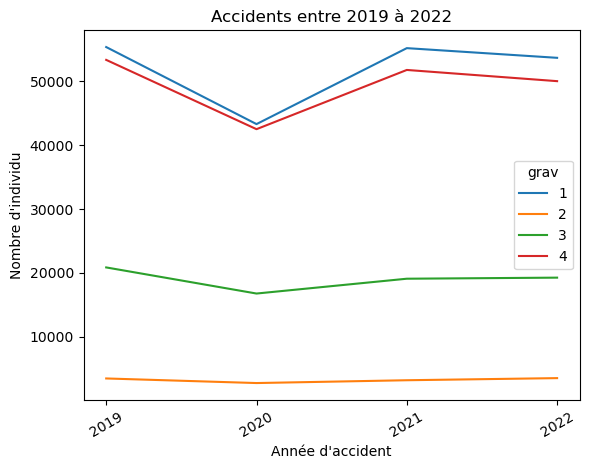

In [24]:
# sous forme dataviz
df_annee = df.loc[df['grav'] >= 1]
df_annee.groupby(['an', 'grav']).size().unstack().plot()

plt.title("Accidents entre 2019 à 2022")
plt.xlabel("Année d'accident")
plt.ylabel("Nombre d'individu")
plt.xticks([2019, 2020, 2021, 2022], rotation=30)
plt.show();

Pour rappel :
- 1 – Indemne
- 2 – Tué
- 3 – Blessé hospitalisé
- 4 – Blessé léger

En 2020, on observe une diminution des accidents et également de la gravité.

In [25]:
# Evolution de décès par rapport aux années précédentes :

dec22 = (3550 - 3219)/3550*100 # par rapport à 2021 = + 9.32 %

dec21 = (3219-2780)/3219*100 # par rapport à 2020 = + 13.64 %

dec20 = (2780-3498)/2780*100 # par rapport à 2019 = - 25.83 %

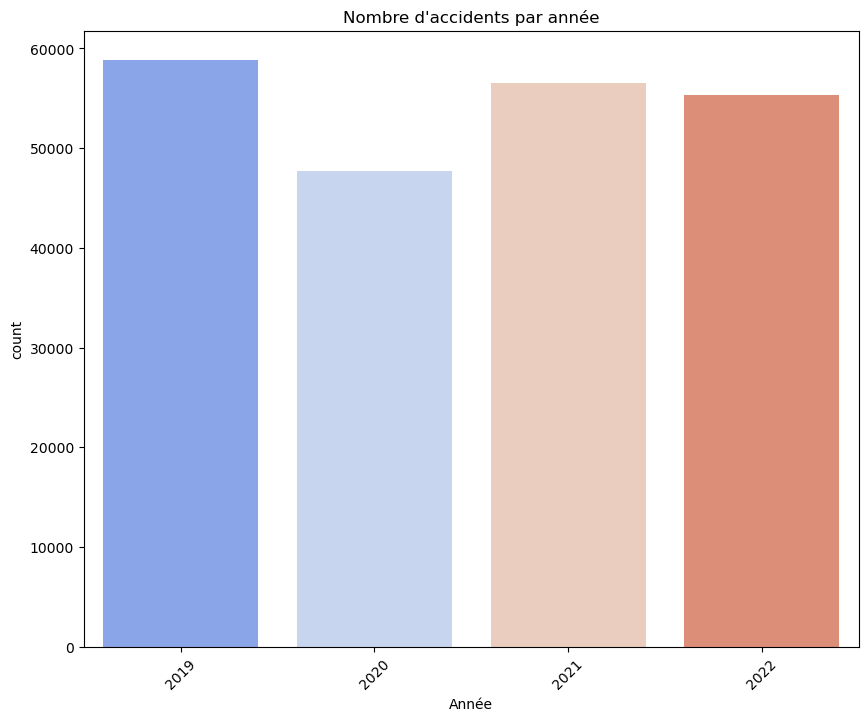

In [26]:
# Representation de nombre d'accidents par années
plt.figure(figsize = (10, 8))

sns.countplot(x = df_car['an'], palette="coolwarm")
plt.title("Nombre d'accidents par année" )
plt.xticks(rotation = 45)
plt.xlabel("Année")
plt.show()

### Valeurs aberrantes

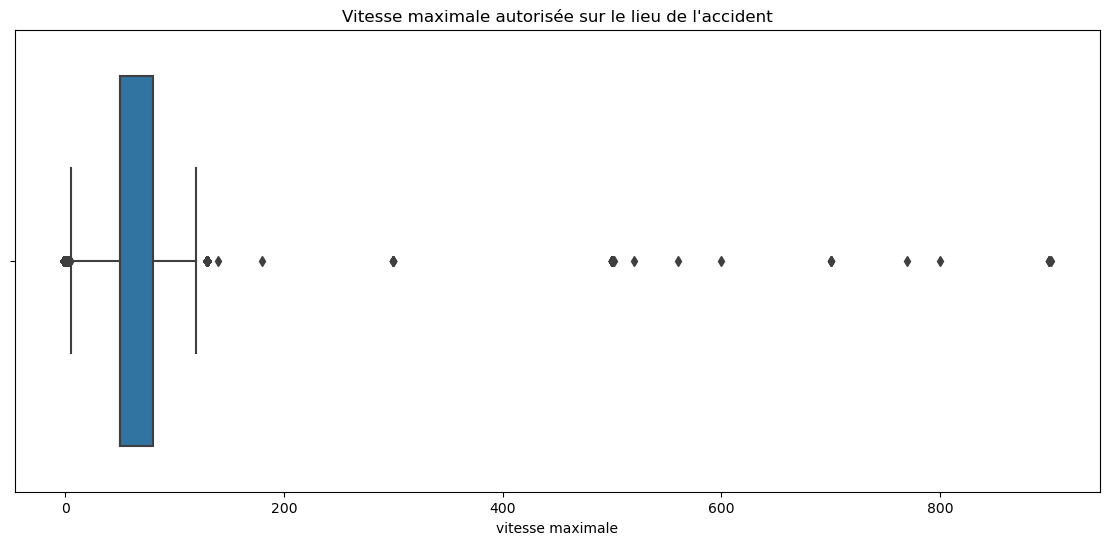

In [27]:
# Representation avec un box plot des valeurs aberrantes
plt.figure(figsize = (14,6))
sns.boxplot(df_lieux, x = 'vma')
plt.xlabel('vitesse maximale')
plt.title("Vitesse maximale autorisée sur le lieu de l'accident")
plt.show()

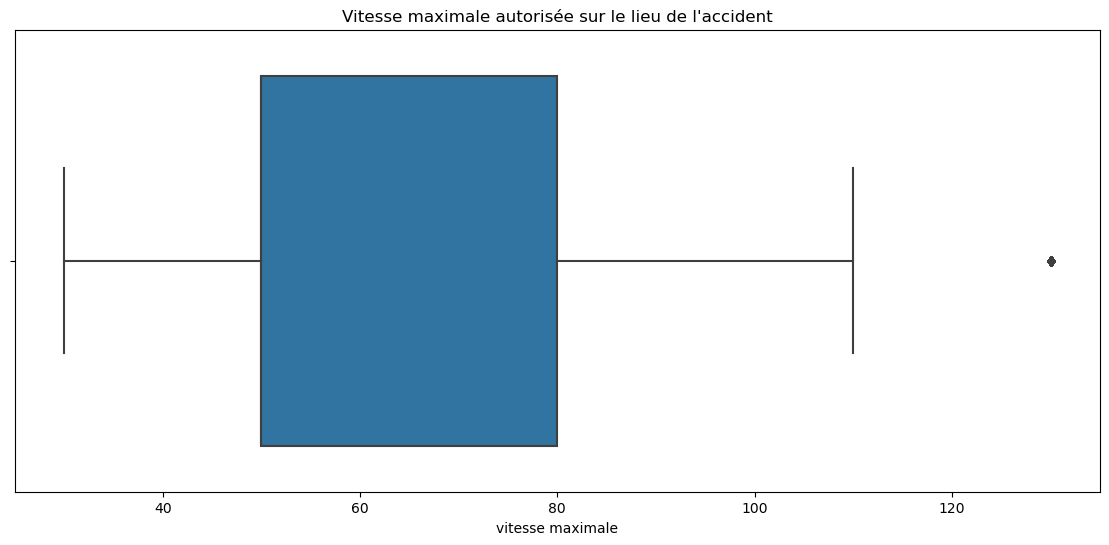

In [28]:
# representation de la vitesse maximale autorisée après l'isolement des valeurs aberrantes
plt.figure(figsize = (14,6))
vma_t =[30,50,70, 80, 90, 110, 130]
df_lieux = df_lieux[df_lieux['vma'].isin(vma_t)].copy()
sns.boxplot(x = 'vma', data = df_lieux)
plt.xlabel('vitesse maximale')
plt.title("Vitesse maximale autorisée sur le lieu de l'accident")
plt.show()

#### Analyse des accidents par rapport aux mois

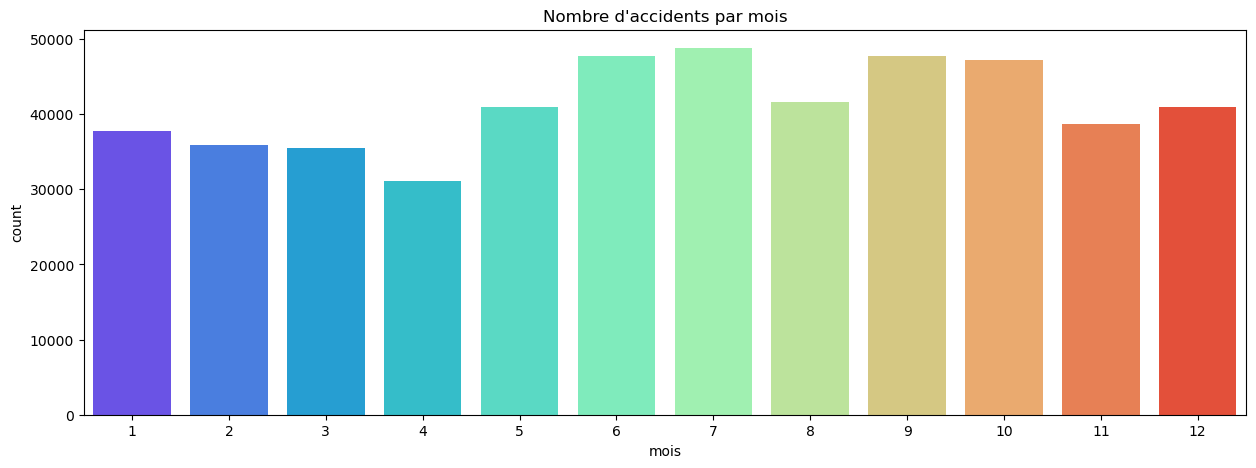

In [29]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(x='mois', data=df, palette='rainbow')
plt.title("Nombre d'accidents par mois")
plt.show()

## Nettoyage des données

In [30]:
# suppression de variables
df = df.drop(["pr", # Numéro du PR de rattachement (numéro de la borne)
              "pr1", # Distance du PR de rattachement en mètre
              "adr", # information déjà contenu dans la latitude et la longitude
              "voie", # numéro de la voie
              "id_vehicule", # colonne qui a permis de faire la jointure
              'Accident_Id', # colonne qui a permis de faire la jointure
              'Num_Acc', # colonne qui a permis de faire la jointure
              "id_usager", # colonne qui a permis de faire la jointure
              'num_veh', # colonne qui a permis de faire la jointure
              "larrout", # 26 % de manquants et forte représentation d'une catégorie
              "secu3",    # bcp de non concernés
              "secu2",    # bcp de non concernés
              "actp",     # bcp de non concernés
              "v1",       # indique le numéro de la route
              "etatp",    # bcp de non concernés
              "lartpc",   # 90% de manquants
              "occutc",   # 90% de manquants
              "v2"        # 90% de manquants
              ], axis=1)

### Sauvegarde du dataset

In [31]:
df.to_csv('dataset/dataset_to_prepro.csv', index=False)

## Bibiographie :

- base de données : https://www.data.gouv.fr/en/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2022/#/resources

- documentation : https://www.data.gouv.fr/en/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2022/#/resources/8ef4c2a3-91a0-4d98-ae3a-989bde87b62a


